# Loan Default Prediction Model Explanation with SHAP Value
Author: Alice Zhou

Machine learning techniques are increasingly being used in the loan default prediction. After constructing a predictive model, it is important to explain the model properly and make users understand it easily.
- Objectives: This report uses a hypothetical loan dataset for loan default prediction. After using supervised machine learning (Random Forest) to build the prediction model, SHAP values will be incorporated to explain the model. 
- Dataset: The dataset contains information on loan application details, borrower's credit history from Credit Bureau, borrower's financial query records, borrower's call records, and third-party data. 

# Table of Contents
- [1. Data Preparation](#1)
    - [1.1 Feature Engineering](#11)
        - [1.1.1 Special Values Handling](#111)
        - [1.1.2 WOE Transformation](#112)
    - [1.2 Train Test Split](#12)
- [2. Modeling](#2)
    - [2.1 RF Modeling](#21)
    - [2.2 Top 10 Important Features](#22)
- [3. Model Interpretation with SHAP Values](#3) 
    - [3.1 Global Interpretability - Variable Importance Plot](#31)
    - [3.2 Global Interpretability- SHAP Dependence Plot](#32)
    - [3.3 Local Interpretability - Individual SHAP Value Plot](#33)
- [4. Conclusion](#4)

## 1. Data Preparation <a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/alicezhou/Documents/Columbia/5420 Anomaly Detection/11. Automated Machine Learning and SHAP/Assignment 11/XYZloan_default_selected_vars.csv') 

Some basic understandings of the raw data:
- Each raw is a borrower (id), and the other variables are the information related to this borrower.
- For the loan default predictive model, "loan_default" is the target variable.
- There are more than 80 variables that can be used as input variables.

In [3]:
# Get the Simple Summary Statistics 
df.describe() 

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,...,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,...,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,39999.500000,40000.500000,40000.500000,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,...,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,23094.155105,23094.155105,23094.155105,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,...,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,1.000000,1.000000,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,19999.750000,20000.750000,20000.750000,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,...,2.000000,5.000000,4.000000,84.000000,34.000000,309.000000,226.00000,539.000000,414.000000,3.000000
50%,39999.500000,40000.500000,40000.500000,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,...,7.000000,12.000000,10.000000,475.000000,397.000000,1023.000000,870.00000,1553.000000,1324.000000,5.000000
75%,59999.250000,60000.250000,60000.250000,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,...,14.000000,23.000000,20.000000,1209.000000,1080.000000,2287.000000,2030.00000,3296.000000,2936.000000,8.000000
max,79999.000000,80000.000000,80000.000000,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,...,1061.000000,2792.000000,1579.000000,48585.000000,29664.000000,88364.000000,54651.00000,125352.000000,87312.000000,47.000000


From the variable statistics, we can see that there are some special values (eg. -99) in some variables (eg. CD172, CD173). I will investigate what other special values and create categories to distinct them later. 

In [4]:
df.shape

(80000, 89)

In [5]:
# Categorize the variables' data source
var = pd.DataFrame(df.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head(10)

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP
5,AP002,int64,AP
6,AP003,int64,AP
7,AP004,int64,AP
8,AP005,object,AP
9,AP006,object,AP


In [6]:
# Investigate variables' data type 
var['dtype'].value_counts()

float64    58
int64      28
object      3
Name: dtype, dtype: int64

In [7]:
# There are 3 categorical variables, and the other are numeric variables
var[var['dtype']=='object']

,varname,dtype,source
8,AP005,object,AP
9,AP006,object,AP
88,MB007,object,MB


In [8]:
# Summarize the data source
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [9]:
# "AP005" is dropped since it's a timestamp data, which cannot be employed in tree-based methods
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP005')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP004', 'AP006', 'AP007', 'AP008', 'AP009']

In [10]:
predictors = CR_list + TD_list + AP_list + MB_list + CD_list + PA_list 

### 1.1 Feature Engineering <a class="anchor" id="11"></a>

#### 1.1.1 Special Values Handling <a class="anchor" id="111"></a>

Next, I will investigate the special values, including missing values (NA), '-99', '-98', '-1'.

In [11]:
# Check missing values
varmissing_df = df[predictors].isnull().sum().to_frame(name='Missing Values').reset_index().rename(columns={'index': 'Variable'})
var_to_WOE1 =varmissing_df[varmissing_df['Missing Values']!=0]['Variable'].tolist()
var_to_WOE1

['TD022',
 'TD023',
 'TD024',
 'TD025',
 'TD026',
 'TD027',
 'TD028',
 'TD029',
 'TD044',
 'TD048',
 'TD051',
 'TD054',
 'TD055',
 'TD061',
 'TD062',
 'MB005',
 'CD008',
 'CD018',
 'CD071',
 'CD072',
 'CD088',
 'CD100',
 'CD101',
 'CD106',
 'CD107',
 'CD108',
 'CD113',
 'CD114',
 'CD115',
 'CD117',
 'CD118',
 'CD120',
 'CD121',
 'CD123',
 'CD130',
 'CD131',
 'CD132',
 'CD133',
 'CD135',
 'CD136',
 'CD137',
 'CD152',
 'CD153',
 'CD160',
 'CD162',
 'CD164',
 'CD166',
 'CD167',
 'CD169',
 'CD170',
 'CD172',
 'CD173',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031']

In [12]:
# Check whether minimum values cover negative values like '-99' 
df[predictors].describe().loc['min']

CR004     1.0
CR005     1.0
CR009     0.0
CR012     0.0
CR015     2.0
         ... 
PA023   -99.0
PA028   -99.0
PA029   -99.0
PA030   -99.0
PA031   -99.0
Name: min, Length: 82, dtype: float64

‘-99’, '-98' and '-1' are very likely missing values and set by the systems as extreme values. In a parametric regression, we can not use them blindly as numeric values. I am going to bin the continuous variable, leaving the special values ‘0’, ‘-99’, and’NA’ as their categories. These numeric variables will be converted to catogorical variables and I will then conduct WOE transformation for these catogorical variables for better capture their patterns.

In [13]:
# Check the other special variables
print(sum(df['PA022']==-99))
print(sum(df['PA022']==-98))
print(sum(df['PA022']==-1))
print(sum(df['PA022']<0))

1534
0
50639
52173


In [14]:
# Check the other special variables
print(sum(df['PA023']==-99))
print(sum(df['PA023']==-98))
print(sum(df['PA023']==-1))
print(sum(df['PA023']<0))

1534
0
56004
57538


In [15]:
# Check the other special variables
print(sum(df['PA028']==-99))
print(sum(df['PA028']==-98))
print(sum(df['PA028']==-1))
print(sum(df['PA028']<0))

1534
50639
0
52173


In [16]:
# Check the other special variables
print(sum(df['PA029']==-99))
print(sum(df['PA029']==-98))
print(sum(df['PA029']==-1))
print(sum(df['PA029']<0))

1534
53086
0
54620


In [17]:
# Check the other special variables
print(sum(df['PA030']==-99))
print(sum(df['PA030']==-98))
print(sum(df['PA030']==-1))
print(sum(df['PA030']<0))

1534
67886
0
69420


In [18]:
# Check the other special variables
print(sum(df['PA031']==-99))
print(sum(df['PA031']==-98))
print(sum(df['PA031']==-1))
print(sum(df['PA031']<0))

1534
56004
0
57538


I will include the categorical variables for future WOE transformation as well.

In [19]:
# Extract categorical variables
var_to_WOE_cat = var[var['dtype']=='object']['varname'].tolist()
var_to_WOE_cat.remove('AP005') # "AP005" is dropped since it's a timestamp data
var_to_WOE_cat

['AP006', 'MB007']

I will also include 'AP002' (CODE_GENDER) and 'AP003' (CODE_EDUCATION) for WOE transformation because these variables are also categorical information. 

In [20]:
var_to_WOE_num = var_to_WOE1 + ['AP002', 'AP003']
var_to_WOE_num

['TD022',
 'TD023',
 'TD024',
 'TD025',
 'TD026',
 'TD027',
 'TD028',
 'TD029',
 'TD044',
 'TD048',
 'TD051',
 'TD054',
 'TD055',
 'TD061',
 'TD062',
 'MB005',
 'CD008',
 'CD018',
 'CD071',
 'CD072',
 'CD088',
 'CD100',
 'CD101',
 'CD106',
 'CD107',
 'CD108',
 'CD113',
 'CD114',
 'CD115',
 'CD117',
 'CD118',
 'CD120',
 'CD121',
 'CD123',
 'CD130',
 'CD131',
 'CD132',
 'CD133',
 'CD135',
 'CD136',
 'CD137',
 'CD152',
 'CD153',
 'CD160',
 'CD162',
 'CD164',
 'CD166',
 'CD167',
 'CD169',
 'CD170',
 'CD172',
 'CD173',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031',
 'AP002',
 'AP003']

In [21]:
# Bin the continuous variable
def binning(df, var):
    # Check for missing values and replace with a default value if necessary
    df[var] = df[var].fillna("-999")

    # Convert the column to a numeric type (if it is not already)
    df[var] = pd.to_numeric(df[var], errors='coerce')

    # Check if the column contains NaN values after conversion
    if df[var].isnull().any():
        print(f"Warning: {var} contains NaN values after conversion. Check the data.")

    # Perform qcut on the numeric data
    if not df[var].empty:
        df[var + '_bin'] = pd.qcut(df[var], 10, duplicates='drop').values.add_categories("NoData")
        df[var + '_bin'] = df[var + '_bin'].fillna("NoData").astype(str)
        df[var + '_bin'].value_counts(dropna=False)
    
    # Handle specific values like -99, -98, and -1
    df.loc[df[var] == -999, var + '_bin'] = "NoData"
    df.loc[df[var] == -99, var + '_bin'] = -99
    df.loc[df[var] == -98, var + '_bin'] = -98
    df.loc[df[var] == -1, var + '_bin'] = -1

# Apply binning to train and test data
for i in var_to_WOE_num:
    binning(df, i)

var_to_WOE_num_bin = [f + '_bin' for f in var_to_WOE_num]
features_bin = var_to_WOE_num_bin + list(var_to_WOE_cat)

/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/67399853.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_bin'] = pd.qcut(df[var], 10, duplicates='drop').values.add_categories("NoData")
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/67399853.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_bin'] = pd.qcut(df[var], 10, duplicates='drop').values.add_categories("NoData")
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/67399853.py:15: PerformanceWarnin

#### 1.1.2 WOE Transformation <a class="anchor" id="112"></a>

Weight of evidence (WOE) transformation is a widely used technique in credit risk modeling or called the probability of default modeling (such models predict how capable an applicant can repay the loan). The goal of WOE transformation is to get the maximum difference among the binned categories relating to the target variable. In this transformation, the information of the target variable has been utilized. The dataset contains many categorical variables with many categories. These categories are distributed very differently are have various significant impact to the possibility of default as discussed above. Therefore, WOE is a good choice for feature engineering here. 

WOE encoding maps each category of the original variable to a continuous value that represents the relationship between that category and the likelihood of the target variable (loan default). The WOE values indicate how much more or less likely a particular education code is to experience the target event (loan default) compared to the overall population.

In [22]:
# Calculate WOE for each category 
import category_encoders as ce

ec = ce.WOEEncoder()

def WOE(df, var):
    df[var] = df[var].fillna('NoData')
    X = df[var]
    y = df['loan_default']
    X_WOE = ec.fit(X, y)
    X_cleaned = ec.transform(X).round(2)
    df[var + '_WOE'] = X_cleaned 
    
for i in features_bin:
    WOE(df, i)  

/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_WOE'] = X_cleaned
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_WOE'] = X_cleaned
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_WOE'] = X_cleaned
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_WOE'] = X_cleaned
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_WOE'] = X_cleaned
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var + '_WOE'] = X_cleaned
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_18914/1477488107.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [23]:
# After WOE transformation, the original variables will be replaced by their WOE 
var_to_drop = var_to_WOE_num + var_to_WOE_cat
var_WOE = df.filter(like='_WOE').columns.tolist()

In [24]:
# Predictors will be the original variables without WOE transformation and new WOE variables
predictors_fe = [x for x in predictors if x not in var_to_drop]
predictors_fe = predictors_fe + var_WOE
predictors_fe

['CR004',
 'CR005',
 'CR009',
 'CR012',
 'CR015',
 'CR017',
 'CR018',
 'CR019',
 'TD001',
 'TD002',
 'TD005',
 'TD006',
 'TD009',
 'TD010',
 'TD013',
 'TD014',
 'TD015',
 'AP001',
 'AP004',
 'AP007',
 'AP008',
 'AP009',
 'TD022_bin_WOE',
 'TD023_bin_WOE',
 'TD024_bin_WOE',
 'TD025_bin_WOE',
 'TD026_bin_WOE',
 'TD027_bin_WOE',
 'TD028_bin_WOE',
 'TD029_bin_WOE',
 'TD044_bin_WOE',
 'TD048_bin_WOE',
 'TD051_bin_WOE',
 'TD054_bin_WOE',
 'TD055_bin_WOE',
 'TD061_bin_WOE',
 'TD062_bin_WOE',
 'MB005_bin_WOE',
 'CD008_bin_WOE',
 'CD018_bin_WOE',
 'CD071_bin_WOE',
 'CD072_bin_WOE',
 'CD088_bin_WOE',
 'CD100_bin_WOE',
 'CD101_bin_WOE',
 'CD106_bin_WOE',
 'CD107_bin_WOE',
 'CD108_bin_WOE',
 'CD113_bin_WOE',
 'CD114_bin_WOE',
 'CD115_bin_WOE',
 'CD117_bin_WOE',
 'CD118_bin_WOE',
 'CD120_bin_WOE',
 'CD121_bin_WOE',
 'CD123_bin_WOE',
 'CD130_bin_WOE',
 'CD131_bin_WOE',
 'CD132_bin_WOE',
 'CD133_bin_WOE',
 'CD135_bin_WOE',
 'CD136_bin_WOE',
 'CD137_bin_WOE',
 'CD152_bin_WOE',
 'CD153_bin_WOE',
 'CD16

### 1.2 Train Test Split <a class="anchor" id="12"></a>

In [25]:
Y=df['loan_default']

In [26]:
# Only keep the variables after feature engineering for modeling 
X=df[predictors_fe] 

In [60]:
df[['MB007','MB007_WOE']]

,MB007,MB007_WOE
0,IPHONE7,-0.08
1,WEB,-0.04
2,WEB,-0.04
3,OPPO,0.30
4,WEB,-0.04
...,...,...
79995,OPPO,0.30
79996,IPHONE7,-0.08
79997,VIVO,0.29
79998,XIAOMI,0.06


In [27]:
# Train test split 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## 2. Modeling <a class="anchor" id="2"></a>

### 2.1 RF Modeling <a class="anchor" id="21"></a>

I am going to use scikit-learn to run random forest model and check the variable importance based on it.

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

### 2.2 Top 10 Important Features <a class="anchor" id="22"></a>

In [29]:
# Check the variable importance values
print(model.feature_importances_)

[1.36937684e-03 1.96309931e-03 1.65642666e-02 0.00000000e+00
 4.47447211e-02 1.48424148e-03 2.50776984e-03 3.74914778e-03
 6.67112246e-03 5.64666978e-03 1.78658310e-02 1.96039944e-03
 3.03313644e-02 6.46200215e-03 3.15972443e-01 5.21270486e-03
 6.93758931e-04 7.73977167e-03 1.97326879e-01 7.80090460e-03
 1.03745491e-03 1.02630371e-03 1.60055098e-03 9.74751390e-04
 1.88960356e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.26024639e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.10769711e-02 3.07127541e-03 6.78005815e-04
 4.66907350e-04 2.55016127e-03 1.04260919e-03 3.69810149e-03
 8.76655424e-04 5.03064092e-03 4.11864685e-03 8.90444106e-03
 6.55242596e-03 9.81195535e-03 2.83335644e-03 4.82865410e-03
 3.11797097e-03 1.11130847e-02 1.78605634e-03 1.92652196e-02
 2.90834251e-03 5.48692391e-04 9.99200636e-04 8.75823547e-04
 3.39321674e-04 1.83111742e-03 1.28401189e-03 4.55025225e-03
 5.28241646e-04 2.682177

Based on the variable importance values, I am going to select the top 10 important variables for coming interpretation.

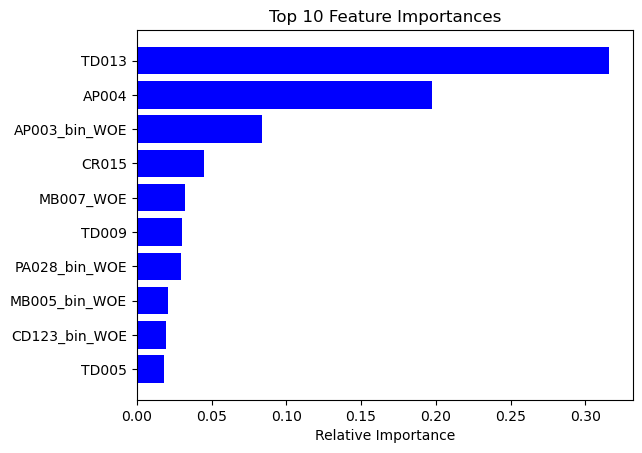

In [30]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

# Extracting the top 10 important variables
top_n = 10
top_indices = indices[-top_n:]
top_importances = importances[top_indices]
top_features = [features[i] for i in top_indices]

plt.title('Top 10 Feature Importances')
plt.barh(range(len(top_indices)), top_importances, color='b', align='center')
plt.yticks(range(len(top_indices)), top_features)
plt.xlabel('Relative Importance')
plt.show()

For the top 10 features, here are their business descriptions:
1. TD013 - TD_CNT_QUERY_LAST_6MON_P2P: Total count of queries related to peer-to-peer (P2P) lending in the last 6 months.
2. AP004 - LOAN_TERM: The term or duration of the loan.
3. AP003_bin_WOE: The transformed and binned version of the original CODE_EDUCATION variable using Weight of Evidence (WOE) encoding. WOE encoding maps each category of the CODE_EDUCATION variable to a continuous value that represents the relationship between that category and the likelihood of the target variable (e.g., loan default). The WOE values indicate how much more or less likely a particular education code is to experience the target event (loan default) compared to the overall population.
    - CODE_EDUCATION: Code representing the level of education of the borrower.
4. CR015 - MONTH_CREDIT_CARD_MOB_MAX: The maximum mobile credit card usage amount in a month.
5. MB007_WOE: The transformed version of the original MOBILE_BRAND variable using WOE encoding. 
    - MOBILE_BRAND: The brand or manufacturer of the borrower's mobile device.
6. TD009 - TD_CNT_QUERY_LAST_3MON_P2P: Total count of queries related to peer-to-peer (P2P) lending in the last 3 months.
7. PA028_bin_WOE: The transformed and binned version of the original AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS variable using WOE encoding. 
    - AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS: Average length of collection or high-risk calls made by the borrower.
8. MB005_bin_WOE: The transformed and binned version of the original YR_PHONE_ACTIVE variable using Weight of Evidence (WOE) encoding. 
    - YR_PHONE_ACTIVE: Number of years the borrower's phone has been active.
9. CD123_bin_WOE: The transformed and binned version of the original CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON variable using WOE encoding. 
    - CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON: Count of distinct outbound calls made by the borrower in the last 3 months.
10. TD005 - TD_CNT_QUERY_LAST_1MON_P2P: Total count of queries related to peer-to-peer (P2P) lending in the last 1 month.

In [31]:
# Select the top 10 important variables
X_train = X_train[["TD013","AP004","AP003_bin_WOE","CR015","MB007_WOE","TD009","PA028_bin_WOE","MB005_bin_WOE","CD123_bin_WOE","TD005"]]
X_test = X_test[["TD013","AP004","AP003_bin_WOE","CR015","MB007_WOE","TD009","PA028_bin_WOE","MB005_bin_WOE","CD123_bin_WOE","TD005"]]
X_train

,TD013,AP004,AP003_bin_WOE,CR015,MB007_WOE,TD009,PA028_bin_WOE,MB005_bin_WOE,CD123_bin_WOE,TD005
78190,1,12,-0.51,6,-0.15,1,-0.15,0.22,-0.37,1
1398,4,12,0.07,5,-0.07,4,-0.15,0.16,-0.16,3
13128,5,12,-0.51,6,-0.04,4,-0.15,0.16,-0.07,4
33383,3,12,-0.51,6,0.08,2,-0.15,-0.23,-0.07,0
50149,14,12,0.07,5,-0.04,8,0.36,0.22,0.08,2
...,...,...,...,...,...,...,...,...,...,...
24483,7,12,0.07,4,0.07,7,-0.15,-0.06,0.08,4
72933,2,12,-0.51,6,-0.04,2,-0.15,-0.13,-0.11,1
13063,11,12,0.07,5,0.29,6,0.17,-0.12,0.08,4
54313,6,12,0.07,5,-0.15,7,-0.15,0.16,-0.07,3


In [32]:
# Use the top 10 important variables for RF modeling and interpretation
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

## 3. Model Interpretation with SHAP Values <a class="anchor" id="3"></a>

SHAP (SHapley Additive exPlanations) is a method for interpreting the predictions of machine learning models. It provides a way to understand the contribution of each feature to a particular prediction. SHAP values are based on cooperative game theory and offer a rigorous and consistent way to distribute the importance of each feature across all predictions made by the model.

For a loan prediction project using a random forest model, SHAP values are suitable for interpretation for the following reasons:

1. Global Interpretability - Feature Importance: SHAP values can help determine the relative importance of each feature in the model's decision-making process. This is crucial for a loan prediction model as it allows you to understand which features have the most significant impact on the loan approval or rejection process. Knowing the most influential features can guide you in focusing on the relevant factors during the loan application process.

2. Local Interpretability - Individual Predictions: SHAP values offer a granular view of how each feature affects individual predictions. For each loan application, you can understand the specific reasons behind the model's decision. This level of interpretability is essential in a loan prediction scenario, as it allows you to provide clear explanations to applicants about why their loan was approved or denied based on their unique circumstances.

3. Consistency and Fairness: SHAP values adhere to several desirable properties, including consistency, meaning the attribution values add up to the model's overall prediction. This is essential for fairness and non-discrimination in loan approval decisions. By using SHAP values, you can ensure that the model is treating all applicants fairly and that the reasons for approval or denial align with the model's overall decision-making process.

4. Model Transparency and Trust: Loan approval decisions can have significant impacts on people's lives, so it's essential to build models that are transparent and trustworthy. SHAP values provide a comprehensible and interpretable way to explain model predictions, increasing the overall transparency of the model and building trust with users and stakeholders.

In [33]:
# Produce SHAP values for the top 10 important features in the above RF model
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### 3.1 Global Interpretability - Variable Importance Plot <a class="anchor" id="31"></a>

We are going to produce the variable importance plot. A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

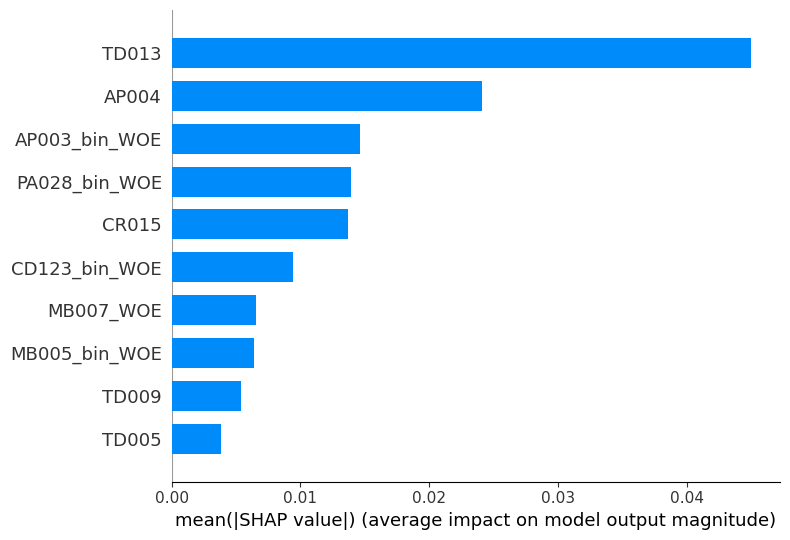

In [34]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

The above variable importance plot ranks the feature importance in descending order. "TD013" (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) shows the largest contribution to the model, and "TD005" (total count of queries related to peer-to-peer (P2P) lending in the last 1 month) has the lowest prediction power.

The below SHAP value plot can show the positive and negative relationships of the predictors with the target variable. 

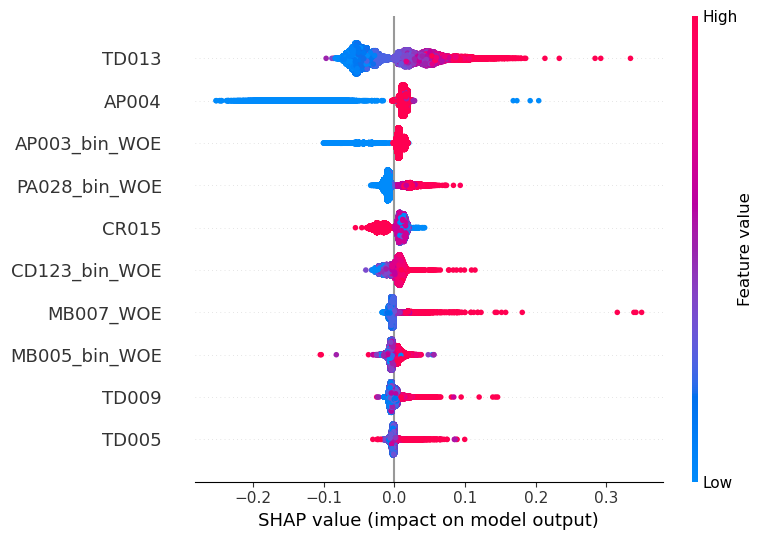

In [35]:
shap.summary_plot(shap_values, X_train)

This plot is made of all the dots in the train data. It delivers the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: A high number of "TD013" (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) has a high and positive impact on the possibility of loan default. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we can say the "CR015" (the maximum mobile credit card usage amount in a month) is negatively correlated with the target variable. Other than "CR015", all the other variables are positively correlated with the target variable. 

### 3.2 Global Interpretability- SHAP Dependence Plot <a class="anchor" id="32"></a>

You may ask how to show a partial dependence plot. A partial dependence plot shows the marginal effect of one or two features on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. As a result, this information can be valuable in the loan default prediction project, as it helps identify important features that contribute to the model's decision-making process. Lenders or financial institutions can use this insight to better assess the creditworthiness of borrowers and make more informed lending decisions. They might consider implementing different risk mitigation strategies or adjusting loan terms based on the observed interactions between these variables.

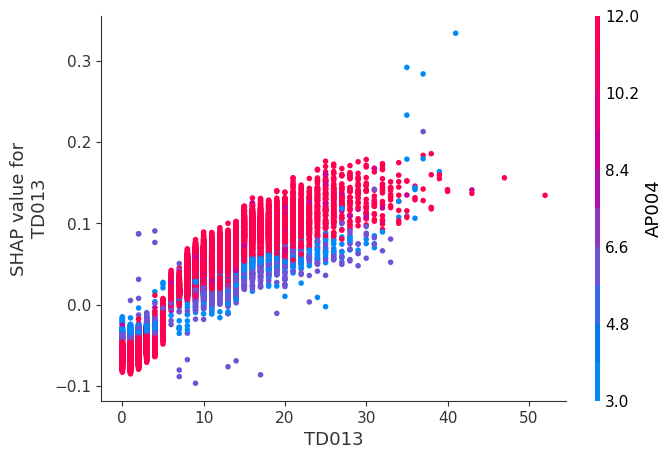

In [36]:
# we pass "TD013" instead of an index because dependence_plot() will find it in X's column names for us
# "AP004" was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("TD013", shap_values, X_train)

- The above plot shows there is an approximately linear and positive trend between “TD013” (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) and the target variable (loan default), and “TD013” highly interacts with “AP004” (the term or duration of the loan in months) frequently. 
- It suggests that borrowers with more queries about P2P lending in the last 6 months are at higher risk of loan defaulting. 
- Additionally, the strong interaction between "TD013" (total count of P2P lending queries) and "AP004" (loan term) indicates that the effect of "TD013" on loan default is related to the value of "AP004" (loan term). This interaction suggests that the relationship between P2P lending query numbers and loan default may vary based on the loan term. For example, for certain loan terms, a higher count of queries related to P2P lending might have a stronger impact on the probability of loan default compared to other loan terms. 
- This insight can help lenders make more accurate risk assessments and tailor lending decisions based on the borrower's query behavior and loan term.

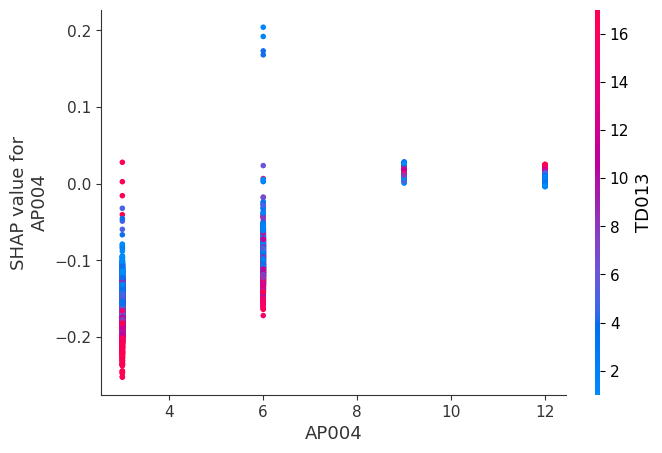

In [37]:
shap.dependence_plot("AP004", shap_values, X_train)

- The above plot demonstrates that as the "AP004" (loan term) increases, there is an approximate positive trend with the target variable, indicating that certain longer-term loans might be associated with a higher probability of loan default. This suggests that borrowers with longer loan terms might have a higher risk of defaulting on their loans.
- The frequent interaction between "AP004" (loan term) and "TD013" (total count of P2P lending queries) implies that the impact of loan term on loan default risk is influenced by the level of P2P lending queries. This suggests that the effect of loan term on default risk may vary associated with the borrower's query behavior related to P2P lending.
- As "AP004" (loan term) is a discrete numeric variable, the plot showcases the risk pattern across specific loan term categories. Each distinct category of loan term represents a different group, and their impact on default risk may not follow a linear relationship.
- This insight allows lenders to make informed decisions about loan terms and effectively manage the risk associated with different loan durations and borrower behaviors.

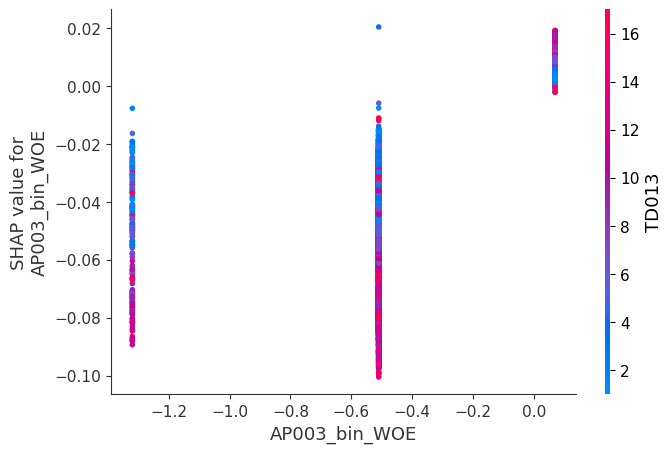

In [38]:
shap.dependence_plot("AP003_bin_WOE", shap_values, X_train)

- The aobve plot shows an approximately positive trend between "AP003_bin_WOE" (WOE-transformed code representing the level of education of the borrower) and the target variable, suggesting that certain categories of the WOE-transformed "CODE_EDUCATION" variable are associated with a higher probability of loan default. This indicates that specific educational backgrounds may influence the risk of loan default, and some categories may exhibit a higher default propensity. However, since the variable dictionary of this dataset does not provide definition of the categories for "CODE_EDUCATION" variable, we cannot tell the meaning of categories that associated with higher default risk. 
- The plot indicates frequent interactions between "AP003_bin_WOE" (WOE-transformed "CODE_EDUCATION") and "TD013" (total count of P2P lending queries). This suggests that the impact of "AP003_bin_WOE" (WOE-transformed "CODE_EDUCATION") on loan default risk is influenced by the level of P2P lending queries. It implies that the effect of education-related WOE on default risk may vary associated with the borrower's query behavior related to P2P lending.
- As "AP003_bin_WOE" is a discrete numeric variable derived from the WOE transformation of the "CODE_EDUCATION" feature, the plot showcases the risk pattern across specific educational categories. Each distinct category represents a different group, and their impact on default risk may not follow a linear relationship.
- This knowledge enables lenders to make informed decisions about lending to borrowers with different educational backgrounds and query behaviors, thus effectively managing loan default risk.

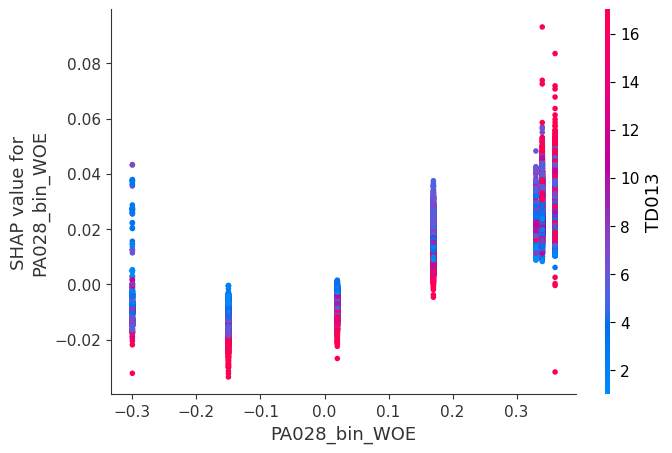

In [40]:
shap.dependence_plot("PA028_bin_WOE", shap_values, X_train)

- The above plot shows an approximately positive trend between "PA028_bin_WOE" (WOE-transformed average length of collection or high-risk calls made by the borrower) and the target variable, suggesting that certain categories of the WOE-transformed "AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS" variable are associated with a higher probability of loan default. This indicates that borrowers with certain average lengths of collection or high-risk calls may be at a higher risk of loan default.
- The plot indicates frequent interactions between "PA028_bin_WOE" (WOE-transformed "AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS") and "TD013" (total count of P2P lending queries). This suggests that the impact of "PA028_bin_WOE" on loan default risk is influenced by the level of P2P lending queries. It implies that the effect of the average length of collection or high-risk calls on default risk may vary associated with the borrower's query behavior related to P2P lending. 
- As "PA028_bin_WOE" is a discrete numeric variable derived from the WOE transformation of the "AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS" feature, the plot showcases the risk pattern across specific average length categories. Each distinct category represents a different group, and their impact on default risk may not follow a linear relationship. 
- This knowledge enables lenders to make informed decisions about lending to borrowers with different average lengths of collection or high-risk calls and query behaviors, thus effectively managing loan default risk.

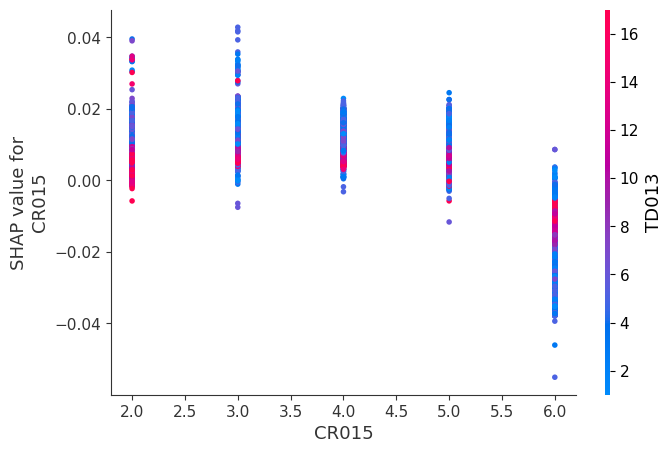

In [39]:
shap.dependence_plot("CR015", shap_values, X_train)

- The plot shows an approximately negative trend between "CR015" (the maximum mobile credit card usage amount in a month) and the target variable, indicating that higher values of the maximum mobile credit card usage amount in a month are associated with a lower probability of loan default. This suggests that borrowers with higher credit card usage may have better creditworthiness and are less likely to default on their loans.
- The plot indicates frequent interactions between "CR015" (the maximum mobile credit card usage amount in a month) and "TD013" (total count of P2P lending queries). This suggests that the impact of "CR015" (the maximum mobile credit card usage amount in a month) on loan default risk is influenced by the level of P2P lending queries. It implies that the effect of the maximum credit card usage on default risk may vary associated with the borrower's query behavior related to P2P lending.
- As "CR015" is a discrete numeric variable, the plot showcases the risk pattern across specific credit card usage amount categories. Each distinct category represents a different group, and their impact on default risk may not follow a linear relationship. 
- Lenders can utilize this knowledge to assess the creditworthiness of borrowers based on their credit card usage and query behavior related to P2P lending, allowing them to make more informed lending decisions and effectively manage loan default risk.

### 3.3 Local Interpretability - Individual SHAP Value Plot <a class="anchor" id="33"></a>

Our machine learning model produces the prediction for a record. To make sense of the prediction, the explainability for any individual observation is the most critical step to convince our audience to adopt our model. I am going to illustrate the interpretations with several examples. 

In [42]:
shap.initjs()

I will arbitrarily select some observations from X_test and show them in the following table.

In [43]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S 

,TD013,AP004,AP003_bin_WOE,CR015,MB007_WOE,TD009,PA028_bin_WOE,MB005_bin_WOE,CD123_bin_WOE,TD005,predict
50885,2,12,-0.51,6,-0.04,2,0.34,0.16,-0.37,2,0.12
62544,7,12,0.07,5,-0.04,4,0.36,-0.23,-0.16,2,0.27
53407,4,12,0.07,2,-0.04,4,0.02,0.22,0.05,3,0.19
64690,13,12,0.07,3,-0.08,12,-0.15,-0.12,0.12,6,0.28
28417,4,12,0.07,3,-0.04,4,-0.15,-0.12,-0.37,3,0.13
47377,9,9,0.07,4,-0.08,4,-0.15,0.22,-0.02,4,0.27
20537,4,6,0.07,6,-0.15,4,-0.30,-0.13,-0.11,3,0.17


Then I will write a function to prepare for the individual SHAP value plot production. 

In [44]:
# Write in a function to produce the SHAP values with force_plot 
# for individual observations in the above table
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model) 
    shap_values_Model = explainerModel.shap_values(S) 
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [45]:
# the average values of the predictors
X_train.mean()

TD013             6.799797
AP004            11.229141
AP003_bin_WOE    -0.012985
CR015             4.927453
MB007_WOE        -0.002967
TD009             5.406469
PA028_bin_WOE    -0.011354
MB005_bin_WOE    -0.009388
CD123_bin_WOE    -0.005251
TD005             3.595828
dtype: float64

In [46]:
# the base value
# the mean prediction 
# the value that would be predicted if we did not know any features for the current output
Y_test.mean()

0.1934375

Here is the interpretation of the individual observations' SHAP value plots:
- The output value is the prediction for that observation.
- The base value: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction of Y_test, 0.19.
- Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

In [48]:
# Individual SHAP Value Plot for Observation 1 of S
shap_plot(1)

- The output value, which is the prediction for this variable is 0.27. It is larger than the base value (0.19), meaning its possibility to default is higher than the average.
- "PA028_bin_WOE" (WOE-transformed average length of collection or high-risk calls made by the borrower) has a positive impact on the target variable (loan default). The value of "PA028_bin_WOE" (0.36) is higher than the average (-0.01), so it pushes the prediction to the right. 
- "TD013" (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) has a positive impact on the target variable (loan default).  The value of "TD013" (7) is higher than the average (6.8), so it pushes the prediction to the right. 
- "AP004" (the term or duration of the loan in months) has a positive impact on the target variable (loan default). The value of "AP004" (12) is higher than the average (11.23), so it pushes the prediction to the right. 
- "CD123_bin_WOE" (count of distinct outbound calls made by the borrower in the last 3 months) has a negative impact on the target variable (loan default). The value of "CD123_bin_WOE" (-0.16) is lower than the average (-0.005), so it pushes the prediction to the left. 
- "MB007_WOE" (WOE-transformed brand or manufacturer of the borrower's mobile device) has a negative impact on the target variable (loan default). The value of "MB007_WOE" (-0.04) is lower than the average (-0.003), so it pushes the prediction to the left. 

In [49]:
shap_plot(2)

- The output value, which is the prediction for this variable is 0.19. It is lower than the base value (0.1937), meaning its possibility to default is lower than the average.
- "CR015" (the maximum mobile credit card usage amount in a month) has a positive impact on the target variable (loan default). "CR015" is negatively correlated to the target variable, and the value of "CR015" (2) is lower than the average (4.93), so it pushes the prediction to the right. 
- "AP004" (the term or duration of the loan in months) has a positive impact on the target variable (loan default). The value of "AP004" (12) is higher than the average (11.23), so it pushes the prediction to the right. 
- "AP003_bin_WOE" (WOE-transformed code representing the level of education of the borrower) has a positive impact on the target variable (loan default).  The value of "AP003_bin_WOE" (0.07) is higher than the average (-0.01), so it pushes the prediction to the right. 
- "TD013" (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) has a negative impact on the target variable (loan default). The value of "TD013" (4) is lower than the average (6.8), so it pushes the prediction to the left. 
- "MB007_WOE" (WOE-transformed brand or manufacturer of the borrower's mobile device) has a negative impact on the target variable (loan default). The value of "MB007_WOE" (-0.04) is lower than the average (-0.003), so it pushes the prediction to the left. 

In [50]:
shap_plot(3)

- The output value, which is the prediction for this variable is 0.28. It is higher than the base value (0.19), meaning its possibility to default is higher than the average.
- "TD013" (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) has a positive impact on the target variable (loan default). The value of "TD013" (13) is higher than the average (6.8), so it pushes the prediction to the right. 
- "AP004" (the term or duration of the loan in months) has a positive impact on the target variable (loan default). The value of "AP004" (12) is higher than the average (11.23), so it pushes the prediction to the right. 
- "AP003_bin_WOE" (WOE-transformed code representing the level of education of the borrower) has a positive impact on the target variable (loan default). The value of "AP003_bin_WOE" (0.07) is higher than the average (-0.01), so it pushes the prediction to the right. 
- "MB005_bin_WOE" (WOE-transformed number of years the borrower's phone has been active) has a negative impact on the target variable (loan default). The value of "MB005_bin_WOE" (-0.12) is lower than the average (-0.009), so it pushes the prediction to the left.
- "PA028_bin_WOE" (WOE-transformed average length of collection or high-risk calls made by the borrower) has a negative impact on the target variable (loan default). The value of "PA028_bin_WOE" (-0.15) is lower than the average (-0.01), so it pushes the prediction to the left. 

In [51]:
shap_plot(4)

- The output value, which is the prediction for this variable is 0.13. It is lower than the base value (0.19), meaning its possibility to default is lower than the average.
- "CR015" (the maximum mobile credit card usage amount in a month) has a positive impact on the target variable (loan default). "CR015" is negatively correlated to the target variable, and the value of "CR015" (3) is lower than the average (4.93), so it pushes the prediction to the right. 
- "AP004" (the term or duration of the loan in months) has a positive impact on the target variable (loan default). The value of "AP004" (12) is higher than the average (11.23), so it pushes the prediction to the right. 
- "AP003_bin_WOE" (WOE-transformed code representing the level of education of the borrower) has a positive impact on the target variable (loan default).  The value of "AP003_bin_WOE" (0.07) is higher than the average (-0.01), so it pushes the prediction to the right. 
- "TD013" (total count of queries related to peer-to-peer (P2P) lending in the last 6 months) has a negative impact on the target variable (loan default). The value of "TD013" (4) is lower than the average (6.8), so it pushes the prediction to the left. 
- "CD123_bin_WOE" (count of distinct outbound calls made by the borrower in the last 3 months) has a negative impact on the target variable (loan default). The value of "CD123_bin_WOE" (-0.37) is lower than the average (-0.005), so it pushes the prediction to the left. 
- "PA028_bin_WOE" (WOE-transformed average length of collection or high-risk calls made by the borrower) has a negative impact on the target variable (loan default). The value of "PA028_bin_WOE" (-0.15) is lower than the average (-0.01), so it pushes the prediction to the left. 
- "MB007_WOE" (WOE-transformed brand or manufacturer of the borrower's mobile device) has a negative impact on the target variable (loan default). The value of "MB007_WOE" (-0.04) is lower than the average (-0.003), so it pushes the prediction to the left. 

## 4. Conclusion <a class="anchor" id="4"></a>

In this report I have demostrated how the SHAP values help to explain the predictions of the machine learning model for loan prediction project. 
- Global Interpretability:
    - The variable importance plot lists the most significant variables in descending order, and the positive and negative relationships of the predictors with the target variable.
    - SHAP dependence plot for each predictor shows its marginal effect on the predicted outcome of the machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 
- Local Interpretability: The individual SHAP value plot shows that how to make sense of the prediction for each individual observation. It shows the association between each feature and the predicted outcome. 
- As a result, this information can be valuable in the loan default prediction project, as it helps identify important features that contribute to the model's decision-making process. Lenders or financial institutions can use this insight to better assess the creditworthiness of borrowers and make more informed lending decisions. They might consider implementing different risk mitigation strategies or adjusting loan terms based on the observed interactions between these variables.